In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

sns.set_theme(style="whitegrid")

#### Q.1 Why does it makes sense to discretize columns for this problem?

Answer: Discretizing columns for a classification problem using decision trees makes sense because decision trees naturally handle categorical data and finite discrete values well.

Discretizing helps reduce the effect of minor observation errors (noise) that might cause the decision tree to overfit. By binning continuous values, small fluctuations in data are removed.

#### Q.2 What might be the issues (if any) if we DID NOT discretize the columns.

Answer: Not discretizing columns in decision tree classification can lead to overfitting, as the model might create overly complex trees that capture noise in the data rather than the underlying patterns.

## 1. Data Quality Analysis (DQA)

In [2]:
df = pd.read_csv('https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true')
df.head(10)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0
5,b. 31-40,e. High,c. High,a. = 0,b. Mid,d. 14,d. Masters,b. income,d. 36-40 & 56-60,train,0
6,a. 0-30,a. Low,b. Mid,a. = 0,a. Low,a. 0-8,a. Low,b. income,e. 40-55,train,0
7,d. 41-50 & 61-70,e. High,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,1
8,d. 41-50 & 61-70,e. High,b. Mid,c. > 0,b. Mid,d. 14,d. Masters,b. income,c. 31-35 & 61-70,train,1
9,b. 31-40,e. High,c. High,c. > 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


All columns are `object` which indicate categorical features, execpt for the target `y` which is either 1 for salaries above 50k or 0 for salaries below 50k

### 1.1. Data quality report
The data quality report provides a comprehensive view of the structure of the data and the characteristics of each feature. This will include both missing values and descriptive statistics of each column.

#### Data quality report for categorical features
All columns in the data are categorical features. We also consider the label a categorical column because its value is either 0 or 1.

In [4]:
# Define a function to create a data quality report for categorical features so we can reuse it later
def data_quality_report_categorical(df):
    reports = []

    for col in df.columns:
        count = df[col].count()
        miss = df[col].isnull().sum()
        card = df[col].nunique()
        mode = df[col].mode()[0]
        mode_freq = df[col].value_counts().iloc[0]
        mode_percent = (mode_freq / count) * 100
        second_mode, second_mode_freq, second_mode_percent = None, None, None
        if card > 1:
            second_mode = df[col].value_counts().index[1]
            second_mode_freq = df[col].value_counts().iloc[1]
            second_mode_percent = (second_mode_freq / count) * 100

        report = {
            "Feature": col,
            "Count": count,
            "Miss.": miss,
            "Card.": card,
            "Mode": mode,
            "Mode Freq.": mode_freq,
            "Mode %": mode_percent,
            "2nd Mode": second_mode,
            "2nd Mode Freq.": second_mode_freq,
            "2nd Mode %": second_mode_percent
        }
        reports.append(report)

    return pd.DataFrame(reports)

In [5]:
categorical_dqr = data_quality_report_categorical(df)
categorical_dqr

,Feature,Count,Miss.,Card.,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
0,hours_per_week_bin,48842,0,5,b. 31-40,26639,54.541174,d. 41-50 & 61-70,9819,20.103599
1,occupation_bin,48842,0,5,c. Mid - Mid,13971,28.604480,b. Mid - Low,12947,26.507924
2,msr_bin,48842,0,3,c. High,22047,45.139429,b. Mid,15868,32.488432
3,capital_gl_bin,48842,0,3,a. = 0,42525,87.066459,c. > 0,4035,8.261332
4,race_sex_bin,48842,0,3,c. High,29737,60.884075,b. Mid,16457,33.694361
5,education_num_bin,48842,0,5,b. 9-12,30324,62.085910,c. 13,8025,16.430531
6,education_bin,48842,0,5,b. Mid,30324,62.085910,c. Bachelors,8025,16.430531
7,workclass_bin,48842,0,2,b. income,46012,94.205806,a. no income,2830,5.794194
8,age_bin,48842,0,5,e. 40-55,13963,28.588100,a. 0-25,9627,19.710495
9,flag,48842,0,2,train,32561,66.665984,test,16281,33.334016


The data quality report shows that:
- There are no missing values in the data.
- Each feature has 2 to 5 categories.
- The majority of data has 0 `capital_gl_bin` and belongs to the income workclass (`workclass_bin`).
- 76% of data belongs to class 0 (<50k) and only 24% belongs to class 1 (>50k)

### 1.2. Visualizations of each feature
We visualize the distribution of each feature using bar plots.

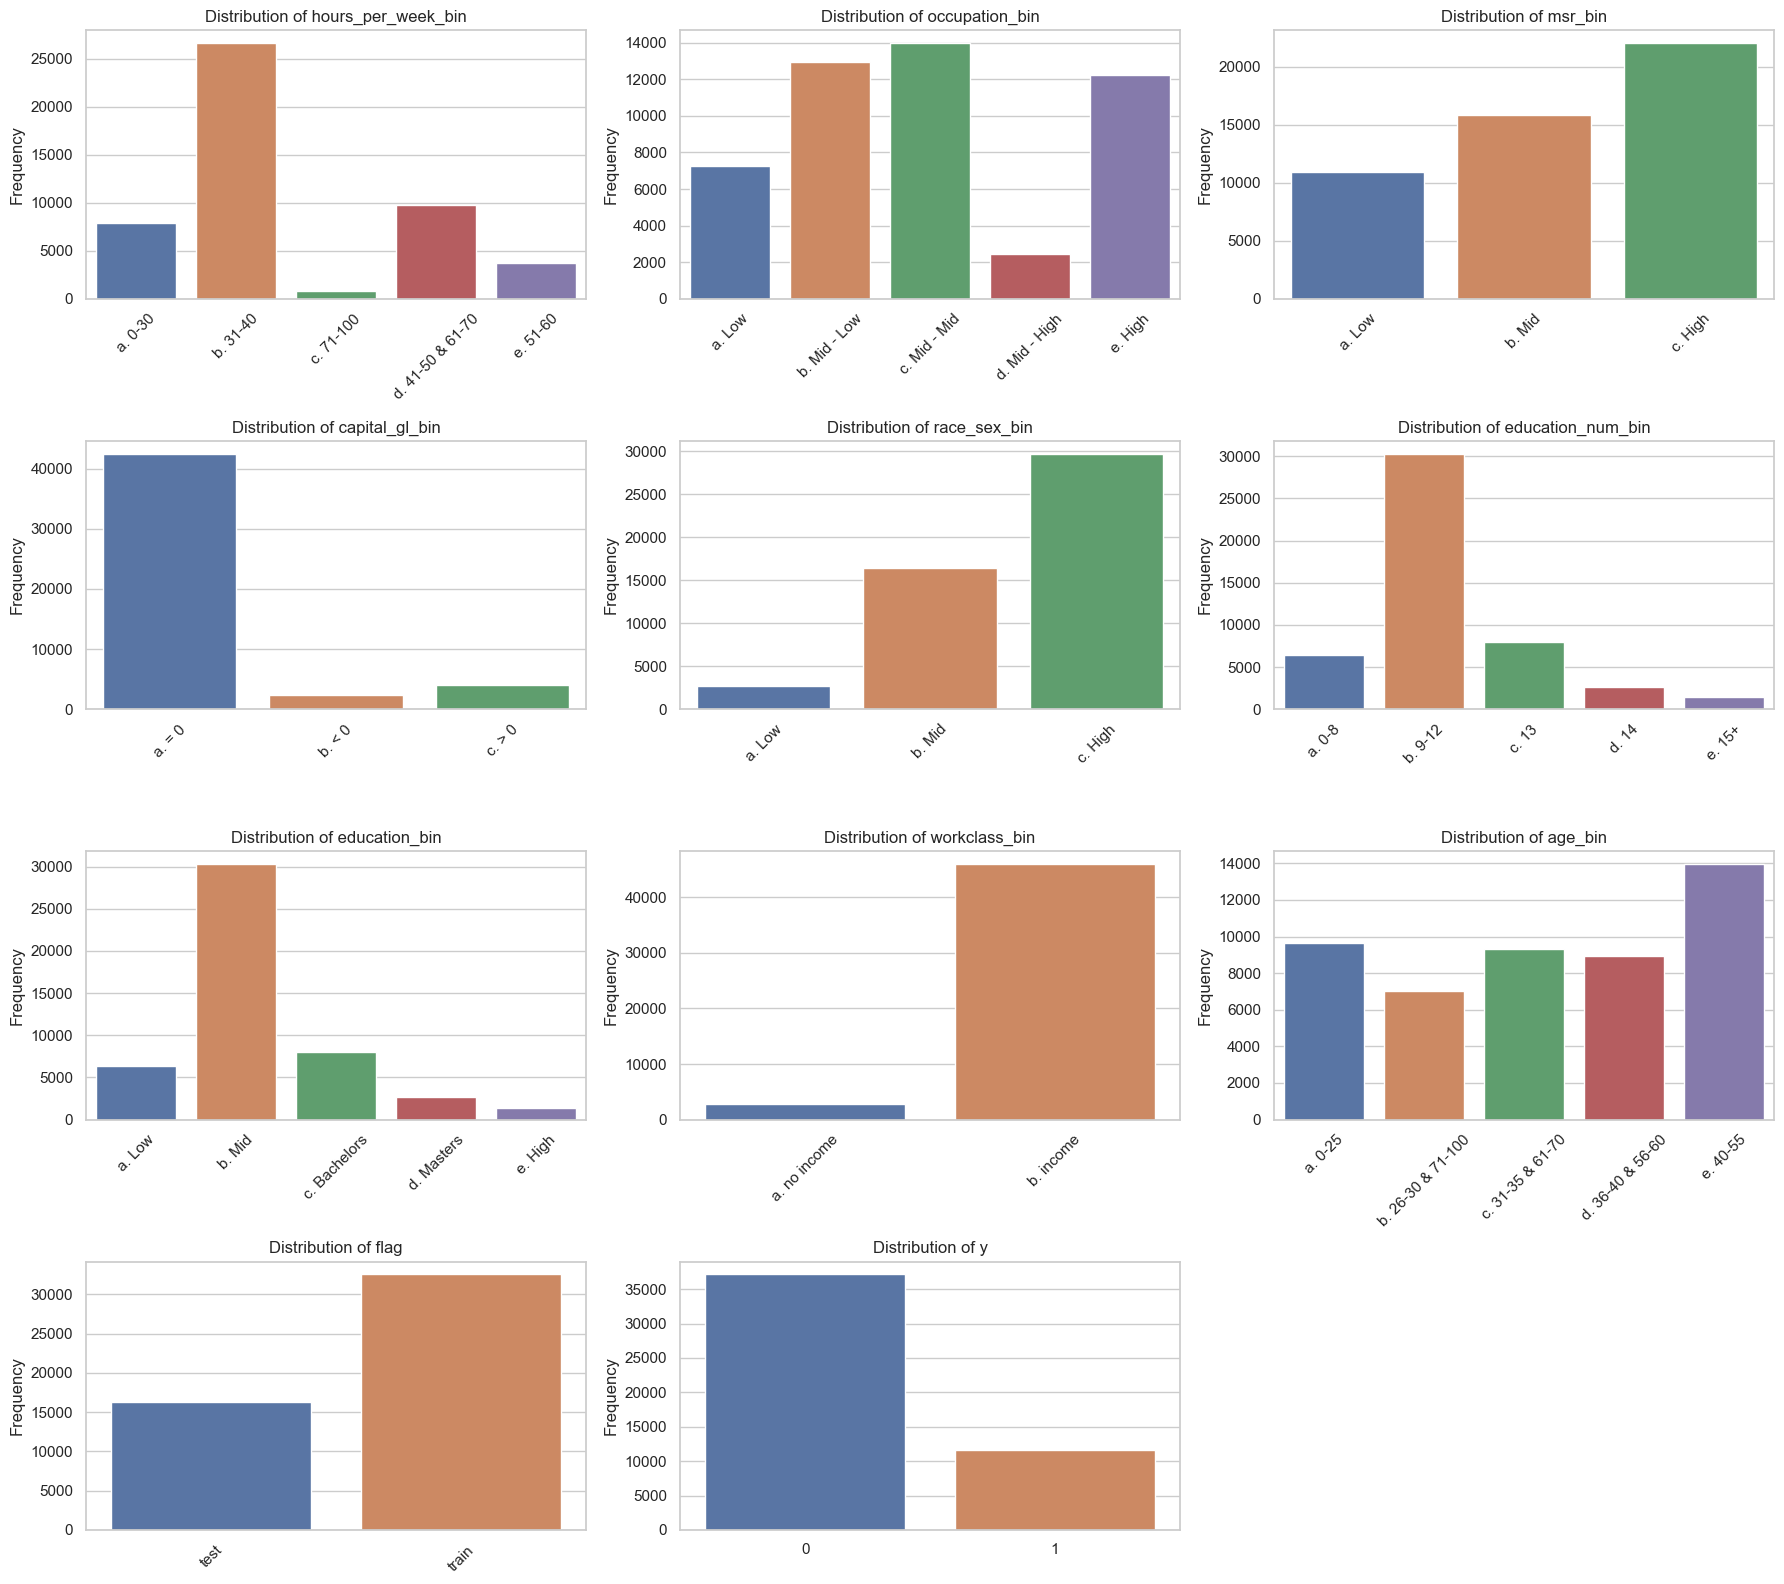

In [6]:
n_unique_values = df.nunique()
n_plots = len(df.columns)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    ax = axes[i]
    sorted_index = df[column].value_counts().sort_index().index
    sorted_values = df[column].value_counts().sort_index().values
    
    if column == 'y':
        sns.countplot(x=df[column], order=sorted_index, ax=ax, hue=df[column], legend=False)
    else:
        category_counts = df[column].value_counts()
        sns.barplot(x=sorted_index, y=sorted_values, ax=ax, hue=sorted_index, legend=False)
    
    ax.set_title(f'Distribution of {column}')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('')
    if column == 'y':
        ax.tick_params(axis='x')
    else:
        ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, n_cols * n_rows):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### 1.2. Data cleaning and transformation

Based on the data quality report:
- There were no missing values, so no imputation is necessary.
- All data points are correctly formatted, and there are no obvious incorrect entries.

Therefore, no data cleaning is needed.

Decision Trees in libraries like scikit-learn require numerical input, so categorical variables must be encoded. For this dataset, since all features except the target are categorical, we will apply one-hot encoding to transform them. Specifically, the next code block will perform the following transformation steps:
- Split the data into a training set and a test set and drop the `flag` feature.
- Apply one-hot encoding to categorical variables.
- Separate the features from the target variable.

In [7]:
# separate train and test set using the 'flag' column
train_data = df[df['flag'] == 'train']
test_data = df[df['flag'] == 'test']

# drop the 'flag' column
train_data = train_data.drop('flag', axis=1)
test_data = test_data.drop('flag', axis=1)

# One-hot encode the categorical variables
X_train = pd.get_dummies(train_data.drop('y', axis=1))
y_train = train_data['y']
X_test = pd.get_dummies(test_data.drop('y', axis=1))
y_test = test_data['y']

# Check the shapes to ensure that the encoding worked correctly
print (X_train.shape, X_test.shape)
print (y_train.shape, y_test.shape)
X_train.head(10)

(32561, 36) (16281, 36)
(32561,) (16281,)


,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 & 61-70,hours_per_week_bin_e. 51-60,occupation_bin_a. Low,occupation_bin_b. Mid - Low,occupation_bin_c. Mid - Mid,occupation_bin_d. Mid - High,occupation_bin_e. High,...,education_bin_c. Bachelors,education_bin_d. Masters,education_bin_e. High,workclass_bin_a. no income,workclass_bin_b. income,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55
0,False,True,False,False,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,True,False
1,True,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,True
2,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
3,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,True,False,False,False
5,False,True,False,False,False,False,False,False,False,True,...,False,True,False,False,True,False,False,False,True,False
6,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
7,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
8,False,False,False,True,False,False,False,False,False,True,...,False,True,False,False,True,False,False,True,False,False
9,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,True


## 2. Build Decision Tree Classifier Models
We first build a decision tree using default hyperparameters, which we will optimize later.

In [8]:
# Initialize the Decision Tree Classifier with default hyperparameters
dt_classifier = DecisionTreeClassifier(random_state=0)

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Predict the labels for the training set and the test set
y_train_pred = dt_classifier.predict(X_train)
y_test_pred = dt_classifier.predict(X_test)

## 3. Evaluate Decision Tree Performance
We evaluate the decision tree on both training and test data with the following metrics:
- Confusion Matrix (TP, TN, FP, FN … etc.)
- Accuracy, Precision, Recall, F1 Score

### 3.1. Confusion matrix

In [9]:
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
TP_train = confusion_matrix_train[1, 1]
TN_train = confusion_matrix_train[0, 0]
FP_train = confusion_matrix_train[0, 1]
FN_train = confusion_matrix_train[1, 0]
print ('Train True Positives (TP):', TP_train)
print ('Train True Negatives (TN):', TN_train)
print ('Train False Positives (FP):', FP_train)
print ('Train False Negatives (FN):', FN_train)

Train True Positives (TP): 4839
Train True Negatives (TN): 23296
Train False Positives (FP): 1424
Train False Negatives (FN): 3002


In [10]:
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
TP_test = confusion_matrix_test[1, 1]
TN_test = confusion_matrix_test[0, 0]
FP_test = confusion_matrix_test[0, 1]
FN_test = confusion_matrix_test[1, 0]
print ('Test True Positives (TP):', TP_test)
print ('Test True Negatives (TN):', TN_test)
print ('Test False Positives (FP):', FP_test)
print ('Test False Negatives (FN):', FN_test)

Test True Positives (TP): 2129
Test True Negatives (TN): 11485
Test False Positives (FP): 950
Test False Negatives (FN): 1717


### 3.2. Accuracy, Precision, Recall, F1 Score

In [11]:
# Calculate the precision, recall, and f1 score for train data
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_score_train = f1_score(y_train, y_train_pred)

# Calculate the precision, recall, and f1 score for test data
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_score_test = f1_score(y_test, y_test_pred)

# Accuracy calculation for train and test data
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

# Organize the evaluation metrics into dictionaries for a clearer presentation
evaluation_metrics_train = {
    "Accuracy": accuracy_train,
    "Precision": precision_train,
    "Recall": recall_train,
    "F1 Score": f1_score_train
}

evaluation_metrics_test = {
    "Confusion Matrix": confusion_matrix_test,
    "Accuracy": accuracy_test,
    "Precision": precision_test,
    "Recall": recall_test,
    "F1 Score": f1_score_test
}

Creating a DataFrame for a nicer display of the metrics for both training and test data

In [12]:
metrics_data = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Training Data": [
        accuracy_train,
        evaluation_metrics_train['Precision'],
        evaluation_metrics_train['Recall'],
        evaluation_metrics_train['F1 Score']
    ],
    "Test Data": [
        accuracy_test,
        evaluation_metrics_test['Precision'],
        evaluation_metrics_test['Recall'],
        evaluation_metrics_test['F1 Score']
    ]
}
metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Metric,Training Data,Test Data
0,Accuracy,0.864071,0.836189
1,Precision,0.772633,0.691458
2,Recall,0.617141,0.553562
3,F1 Score,0.686188,0.614874


## 4. Tune Decision Tree Performance

Helper function to plot a line graph with hyperparameter values as x-axis and accuracy as y-axis

In [13]:
def plot_hyperparameter_vs_metric(df, hyperparameter_col, metric_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(df[hyperparameter_col], df[metric_col], marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

### Run 1: Varying split criterion

In [14]:
criterion_options = ['entropy', 'gini']
results_run1 = []

# Loop over the 'criterion' hyperparameter options
for criterion_option in criterion_options:
    # Initialize the DecisionTreeClassifier with the current criterion option
    dt_classifier = DecisionTreeClassifier(criterion=criterion_option, random_state=0)
    
    # Fit the classifier on the training data
    dt_classifier.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred_test = dt_classifier.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    results_run1.append({
        'Criterion': criterion_option,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
    })

results_run1_df = pd.DataFrame(results_run1)
results_run1_df

,Criterion,Accuracy,Recall,Precision,F1 Score
0,entropy,0.835330,0.554602,0.687843,0.614078
1,gini,0.836189,0.553562,0.691458,0.614874


Determine the best criterion for Run 1

In [15]:
best_criterion = results_run1_df.loc[results_run1_df['Accuracy'].idxmax()]['Criterion']
print (best_criterion)

gini


### Run 2: Varying minimum sample leaf

In [16]:
min_samples_leaf_options = [5, 10, 15, 20, 25, 30, 35, 40]
results_run2 = []

# Perform Run 2 by varying 'min_samples_leaf' using the best criterion from Run 1
for min_samples_leaf in min_samples_leaf_options:
    # Initialize the model with the best criterion and current 'min_samples_leaf'
    model = DecisionTreeClassifier(criterion=best_criterion, min_samples_leaf=min_samples_leaf, random_state=0)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results_run2.append({
        'Min Samples Leaf': min_samples_leaf,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
    })

# Convert the results to a DataFrame for display
results_run2_df = pd.DataFrame(results_run2)
results_run2_df

,Min Samples Leaf,Accuracy,Recall,Precision,F1 Score
0,5,0.838462,0.556942,0.698175,0.619612
1,10,0.839998,0.561102,0.701789,0.623609
2,15,0.841902,0.560322,0.709348,0.626089
3,20,0.844051,0.565523,0.714755,0.631441
4,25,0.843314,0.566303,0.711532,0.630665
5,30,0.842270,0.557202,0.712434,0.625328
6,35,0.843069,0.559802,0.714096,0.627605
7,40,0.842454,0.556942,0.713287,0.625493


Determine the best min sample leaf value for Run 2

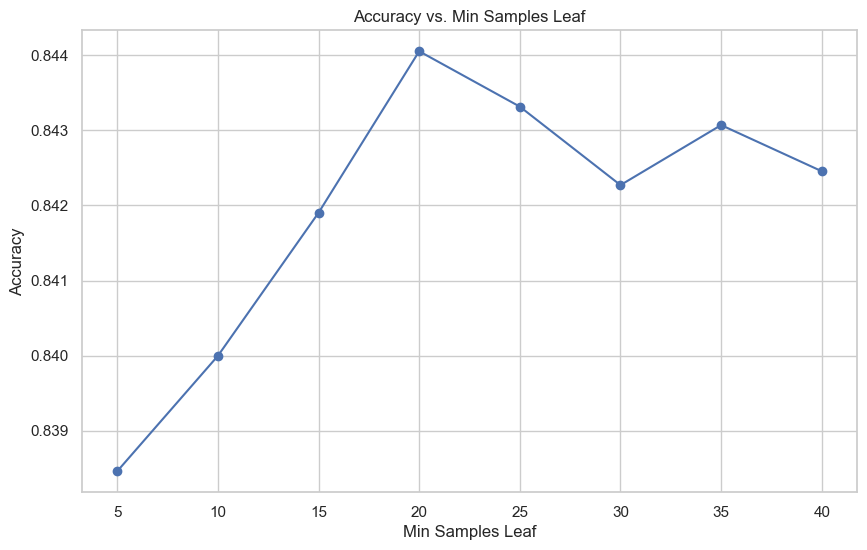

In [17]:
plot_hyperparameter_vs_metric(results_run2_df, 'Min Samples Leaf', 'Accuracy', 'Accuracy vs. Min Samples Leaf', 'Min Samples Leaf', 'Accuracy')

In [18]:
best_min_samples_leaf = int(results_run2_df.loc[results_run2_df['Accuracy'].idxmax()]['Min Samples Leaf'])
print (best_min_samples_leaf)

20


### Run 3: Varying maximum feature

In [19]:
max_features_options = ['auto', None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
results_run3 = []

# Perform Run 3 by varying 'max_features' using the best values from previous runs
for max_features in max_features_options:
    # Initialize the model with the best values so far and the current 'max_features'
    model = DecisionTreeClassifier(
        criterion=best_criterion,
        min_samples_leaf=best_min_samples_leaf,
        max_features=max_features,
        random_state=0
    )
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict the labels on the test data
    y_pred = model.predict(X_test)
    
    # Calculate the performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Append the performance metrics to the results list
    results_run3.append({
        'Max Features': max_features,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
    })

results_run3_df = pd.DataFrame(results_run3)
results_run3_df

/Users/tungnd/miniconda3/envs/numpy/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


,Max Features,Accuracy,Recall,Precision,F1 Score
0,auto,0.836128,0.511700,0.713561,0.596002
1,None,0.844051,0.565523,0.714755,0.631441
2,0.3,0.841963,0.574103,0.702514,0.631850
3,0.4,0.842332,0.565003,0.708510,0.628671
4,0.5,0.843621,0.553822,0.719595,0.625918
5,0.6,0.845034,0.575143,0.713318,0.636822
6,0.7,0.842884,0.569943,0.708010,0.631518
7,0.8,0.843130,0.567863,0.710013,0.631031


Determine the best maximum feature value.

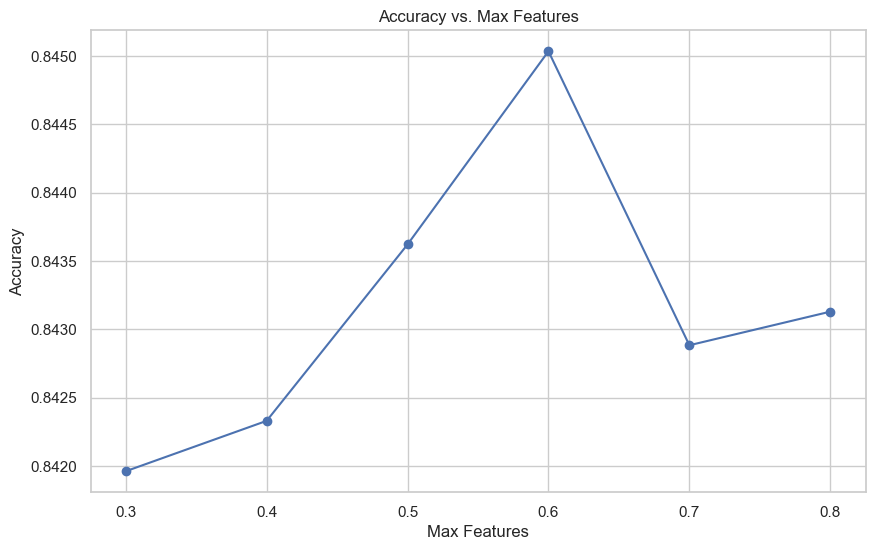

In [20]:
# drop auto and None
results_run3_df_ = results_run3_df.drop([0, 1])
plot_hyperparameter_vs_metric(results_run3_df_, 'Max Features', 'Accuracy', 'Accuracy vs. Max Features', 'Max Features', 'Accuracy')

In [21]:
best_max_features = results_run3_df.loc[results_run3_df['Accuracy'].idxmax()]['Max Features']
print (best_max_features)

0.6


### Run 4: Varying maximum depth

In [22]:
max_depth_options = [2, 4, 6, 8, 10, 12, 14, 16]
results_run4 = []

# Perform Run 4 by varying 'max_depth' using the best values from previous runs
for max_depth in max_depth_options:
    # Initialize the model with the best values so far and the current 'max_depth'
    model = DecisionTreeClassifier(
        criterion=best_criterion,
        min_samples_leaf=best_min_samples_leaf,
        max_features=best_max_features,
        max_depth=max_depth,
        random_state=0
    )
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict the labels on the test data
    y_pred = model.predict(X_test)
    
    # Calculate the performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results_run4.append({
        'Max Depth': max_depth,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
    })

results_run4_df = pd.DataFrame(results_run4)
results_run4_df

,Max Depth,Accuracy,Recall,Precision,F1 Score
0,2,0.816596,0.397816,0.695455,0.506120
1,4,0.834961,0.539262,0.693878,0.606876
2,6,0.838032,0.565783,0.692332,0.622693
3,8,0.842639,0.599064,0.693141,0.642678
4,10,0.845464,0.576703,0.714102,0.638090
5,12,0.843867,0.565003,0.714333,0.630952
6,14,0.844297,0.568643,0.714006,0.633087
7,16,0.845894,0.563963,0.722759,0.633562


Determine the best value for maximum depth

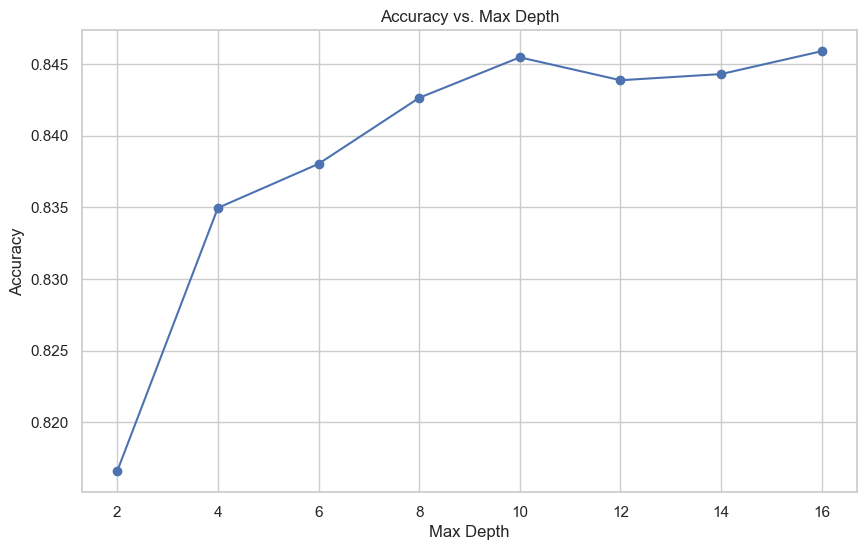

In [23]:
plot_hyperparameter_vs_metric(results_run4_df, 'Max Depth', 'Accuracy', 'Accuracy vs. Max Depth', 'Max Depth', 'Accuracy')

In [24]:
best_max_depth = int(results_run4_df.loc[results_run4_df['Accuracy'].idxmax()]['Max Depth'])
print (best_max_depth)

16


## 5. Visualize The Best Decision Tree

Best Tree Performance on train set: {'Accuracy': 0.8472405638647462, 'Recall': 0.5700803468945288, 'Precision': 0.7360447884077063, 'F1 Score': 0.6425183268650281}
Best Tree Performance on test set: {'Accuracy': 0.8458939868558443, 'Recall': 0.5639625585023401, 'Precision': 0.7227590803065644, 'F1 Score': 0.6335621440046736}


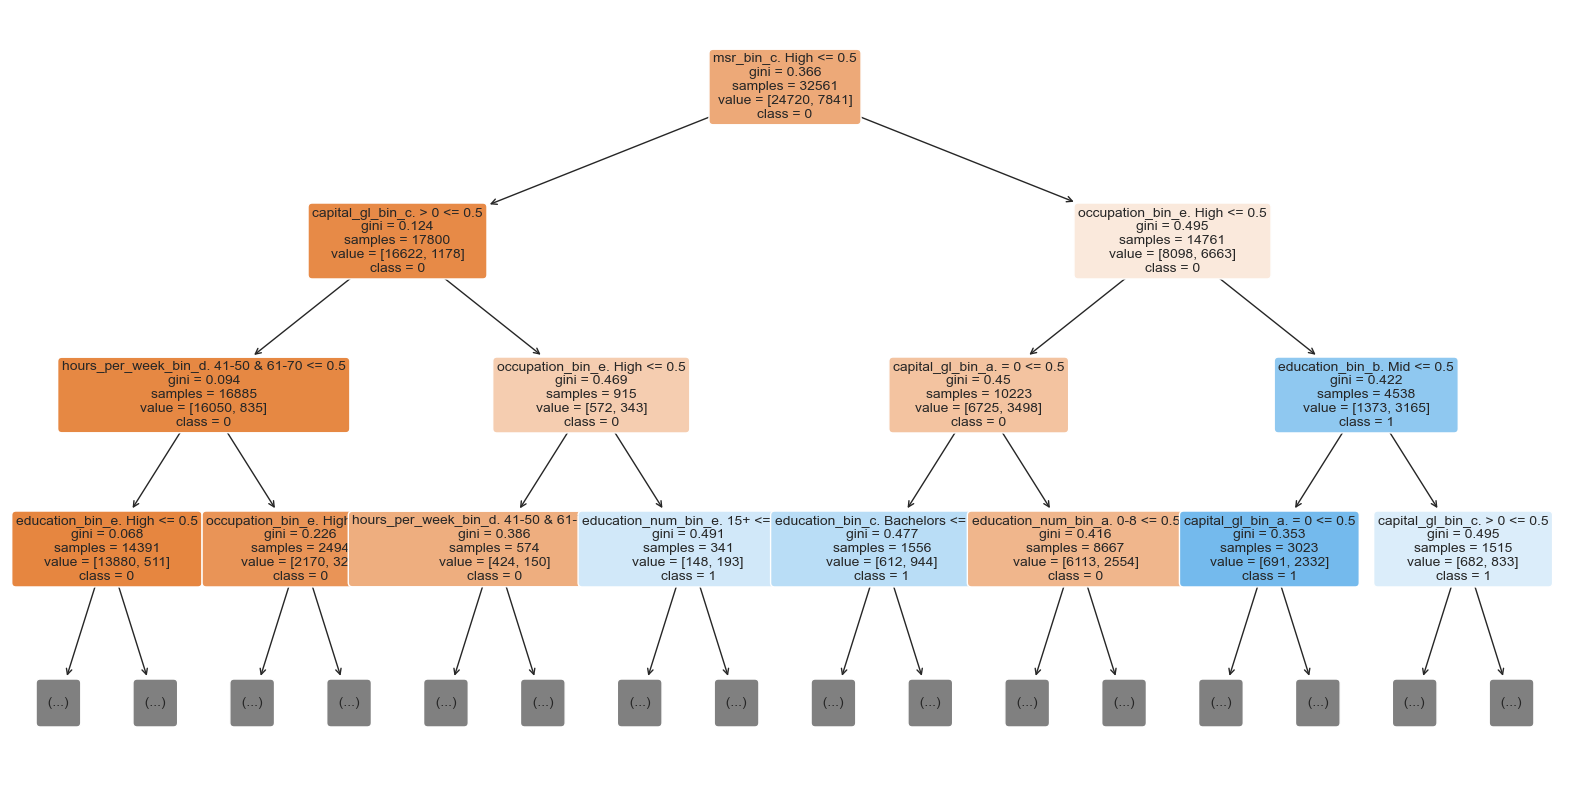

In [25]:
# Initialize the Decision Tree Classifier with the best hyperparameters
best_tree = DecisionTreeClassifier(
    criterion=best_criterion,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    max_depth=best_max_depth,
    random_state=0
)

# Train the best tree
best_tree.fit(X_train, y_train)

# Predict on the train set
y_pred_train_best = best_tree.predict(X_train)
best_tree_performance_train = {
    'Accuracy': accuracy_score(y_train, y_pred_train_best),
    'Recall': recall_score(y_train, y_pred_train_best),
    'Precision': precision_score(y_train, y_pred_train_best),
    'F1 Score': f1_score(y_train, y_pred_train_best)
}

# Predict on the test set
y_pred_best = best_tree.predict(X_test)
best_tree_performance = {
    'Accuracy': accuracy_score(y_test, y_pred_best),
    'Recall': recall_score(y_test, y_pred_best),
    'Precision': precision_score(y_test, y_pred_best),
    'F1 Score': f1_score(y_test, y_pred_best)
}

# Output the performance
print ('Best Tree Performance on train set:', best_tree_performance_train)
print ('Best Tree Performance on test set:', best_tree_performance)

# Plotting the decision tree
plt.figure(figsize=(20,10))
plot_tree(
    best_tree,
    filled=True,
    rounded=True,
    class_names=["0", "1"],
    feature_names=X_train.columns,
    max_depth=3,  # Limiting depth for readability
    fontsize=10
)

plt.show()

## 6. Conclusion

#### Q.4 How long was your total run time to train the best model?

Answer: It took 29.5 ms to train the best model on average

In [26]:
best_tree = DecisionTreeClassifier(
    criterion=best_criterion,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    max_depth=best_max_depth,
    random_state=0
)

%timeit best_tree.fit(X_train, y_train)

29.5 ms ± 353 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Q.5 Did you find the BEST TREE?

Answer: We performed hyperparameter tuning using sequential search, which means in each run we only vary one hyperparameter while keeping other hyperparameters fixed. While this is efficient, it does not try all possible combinations of different hyperparameters. Therefore, it is NOT GUARANTEED that we found the BEST TREE.

#### Q.6 Write your observations from the visualization of the best tree

Answer: The decision tree prioritizes capital gains/losses as the initial split, suggesting it's a key determinant of income category. Subsequent splits on occupation and marital status/relationship status indicate their importance in the absence or presence of capital gains.

#### Q.7 Will this Tree “overfit”? (Hint: Is this tree “fully grown”)

Answer: This Tree does not overfit because it is not fully grown. At each split the tree only considers approximately 60% of the features, which helps introduce randomness into the feature selection process. Moreover, setting the minimum samples leaf to 20 ensures that each leaf node has at least 20 samples, which can help prevent the tree from growing too complex and overfitting to the training data. Another important evidence is the test performance of the model is very close to the train performance.

## 7. Prediction for a new data point

In [27]:
# Create a dictionary for the new individual's data
new_individual = {
    'hours_per_week_bin': 'd. 41-50 & 61-70',  # 48
    'occupation_bin': 'b. Mid - Low',
    'msr_bin': 'c. High',
    'capital_gl_bin': 'c. > 0',  # Assuming 'Yes' for capital gain translates to 'c. > 0'
    'race_sex_bin': 'b. Mid',
    'education_num_bin': 'b. 9-12',  # 12
    'education_bin': 'e. High',
    'workclass_bin': 'b. income',
    'age_bin': 'd. 36-40 & 56-60'  # 58
}

# Convert the dictionary to a DataFrame
new_individual_df = pd.DataFrame([new_individual])

# Apply the same encoding as the training data
new_individual_encoded = pd.get_dummies(new_individual_df).reindex(columns=X_train.columns, fill_value=0)

# Predict the income
income_prediction = best_tree.predict(new_individual_encoded)
income_category = '<=50K' if income_prediction[0] == 0 else '>50K'
print(f'The predicted income category for the new individual is: {income_category}')

The predicted income category for the new individual is: >50K


## Q.8 What is the probability that your prediction for this person is correct?

Answer: The probability that this person makes more than 50K is 79%.

In [28]:
# Obtain the probabilistic prediction for the new individual
probabilities = best_tree.predict_proba(new_individual_encoded)

# The first element of the array is the probability of class 0, and the second is the probability of class 1.
prob_lessthan_equal_50K = probabilities[0][0]
prob_greaterthan_50K = probabilities[0][1]

print(f"The probability that the individual earns <=50K is: {prob_lessthan_equal_50K:.2f}")
print(f"The probability that the individual earns >50K is: {prob_greaterthan_50K:.2f}")

The probability that the individual earns <=50K is: 0.21
The probability that the individual earns >50K is: 0.79


## Github link

https://github.com/duong-pham-2601/CA03-Decision-Tree